In [30]:
import pandas as pd
from pivottablejs import pivot_ui
import matplotlib.pyplot as plt
import seaborn
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from collections import OrderedDict as odict
import warnings
import datetime

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('data_synth_train.csv')

#pivot_ui(df, url="http://localhost:8501")

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
# Estrai ore e minuti e convertili in un numero totale di minuti
df['hour_minute'] = df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute

In [5]:
df_melted = df.melt(id_vars=['hour_minute'], value_vars=["Living room","Bedroom","Bathroom","Kitchen","Hallway"],
                    var_name='feature', value_name='value')

In [6]:
df_filtered = df_melted[df_melted['value'] == 1]

/home/fabio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


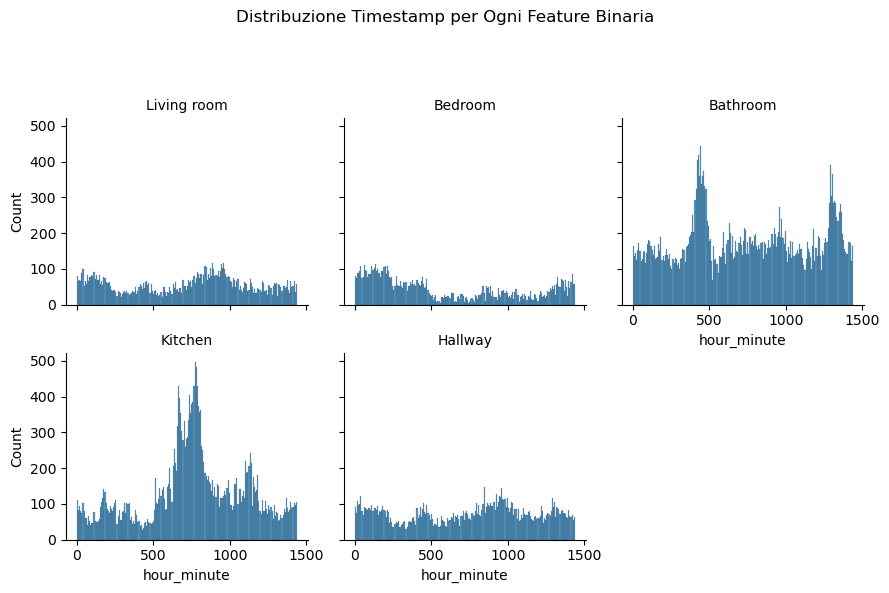

<Figure size 640x480 with 0 Axes>

In [9]:
g = seaborn.FacetGrid(df_filtered, col='feature', col_wrap=3)  # 'col_wrap' per controllare quante colonne per riga

# Mappa l'istogramma all'ora e minuto per ogni feature
g.map(seaborn.histplot, 'hour_minute', bins = 200)

# Regola l'aspetto dei grafici
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Distribuzione Timestamp per Ogni Feature Binaria')

plt.show()

plt.savefig('Distr_temp.png')

In [34]:
df['date'] = df['timestamp'].dt.date

df


data = df[df['Bathroom'] == 1]['date']


df[df['date'] == datetime.date(2019, 11, 7)]['Bathroom'].sum()
#seaborn.histplot(data.values, bins = 90)



263

In [41]:
for i in range(1, 31):
    print(i, '-->', df[df['date'] == datetime.date(2019, 11, i)]['Hallway'].sum()) 

1 --> 0
2 --> 0
3 --> 0
4 --> 0
5 --> 0
6 --> 0
7 --> 92
8 --> 49
9 --> 38
10 --> 29
11 --> 29
12 --> 103
13 --> 48
14 --> 2539
15 --> 1536
16 --> 128
17 --> 43
18 --> 50
19 --> 239
20 --> 109
21 --> 34
22 --> 101
23 --> 43
24 --> 80
25 --> 52
26 --> 312
27 --> 62
28 --> 44
29 --> 704
30 --> 68


In [38]:
20*3178/60/60

17.655555555555555

In [29]:
pd.to_datetime("2019-11-07", format="%Y-%m-%d")

df.iloc[5, -1]

datetime.date(2019, 11, 7)

In [25]:
df

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue,Living room,Bedroom,Bathroom,Kitchen,Hallway,hour_minute,day,date
0,2019-11-07 00:00:07,21.26,57.74,109,531,489,705,659,600,122,0,0,0,0,0,0,307,2019-11-07
1,2019-11-07 00:00:27,21.19,58.03,107,533,494,707,658,603,122,0,0,0,0,0,0,307,2019-11-07
2,2019-11-07 00:00:47,21.11,57.53,107,530,491,708,656,596,121,1,0,0,0,0,0,307,2019-11-07
3,2019-11-07 00:01:07,21.12,57.94,106,532,489,710,656,597,126,1,0,0,0,0,1,307,2019-11-07
4,2019-11-07 00:01:27,21.06,58.18,103,532,490,705,658,597,130,1,0,0,0,0,1,307,2019-11-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304563,2020-01-17 03:51:43,22.05,55.20,102,530,441,692,651,583,108,0,0,0,0,0,231,17,2020-01-17
304564,2020-01-17 03:52:03,21.93,55.13,104,529,441,694,651,583,108,0,0,0,0,0,232,17,2020-01-17
304565,2020-01-17 03:52:23,22.09,55.12,101,529,443,694,651,584,109,0,0,0,0,0,232,17,2020-01-17
304566,2020-01-17 03:52:43,22.04,55.22,101,529,441,694,651,585,108,0,0,0,0,0,232,17,2020-01-17
